## 1. Necessary Imports 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import svm

from sklearn import metrics
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

## 2. Data Load & Description 

In [3]:
data=pd.read_csv('loan.csv')

In [4]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


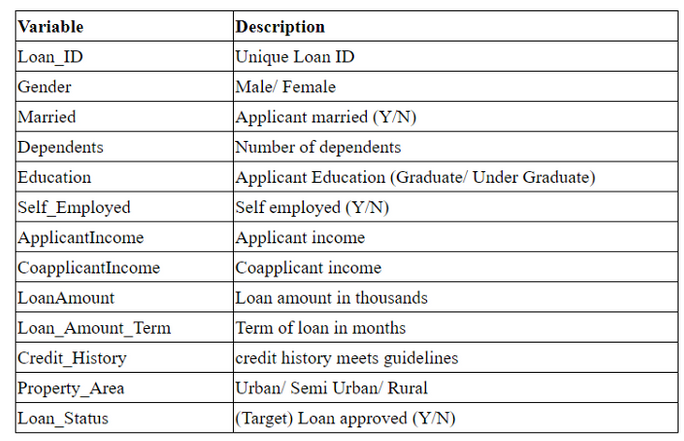

## 3. Handling Missing Values

In [5]:
data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [6]:
data.shape

(614, 13)

In [7]:
data=data.dropna()

In [8]:
data.shape

(480, 13)

In [9]:
data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

## 4. Deleting Unnecessary Columns 

In [10]:
del data['Loan_ID']

In [11]:
data.shape

(480, 12)

## 5. Check Class Distribution 

In [12]:
data['Loan_Status'].value_counts(normalize=True)

Y    0.691667
N    0.308333
Name: Loan_Status, dtype: float64

## 6. Check Data Types 

In [13]:
data.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

## 7. Discretize the Numeric Columns 

### Compute Quartiles

In [14]:
Q1=data['ApplicantIncome'].quantile(0.25)

In [15]:
Q2=data['ApplicantIncome'].quantile(0.50)

In [16]:
Q3=data['ApplicantIncome'].quantile(0.75)

In [17]:
IQR=Q3-Q1

In [18]:
u_whisker=Q3+1.5*IQR

In [19]:
l_whisker=Q1-1.5*IQR

In [20]:
u_whisker

10283.125

In [21]:
l_whisker

-1531.875

### Plot Boxplots of all Numeric Features

In [22]:
def show_boxplots(data): 
    num_col=[]
    for col in data.columns:
        if (data[col].dtype=='int64')or(data[col].dtype=='float64'):
            num_col.append(col)
    data=data[num_col]
    #len(num_col)
        
    cols=data.columns

    #  Categorical Data
    a = 2  # number of rows
    b = 3  # number of columns
    c = 1  # initialize plot counter

    fig = plt.figure(figsize=(30,12))

    for i in cols:
        plt.subplot(a, b, c)
        plt.title('{}, subplot: {}{}{}'.format(i, a, b, c))
        plt.xlabel(i)
        sns.boxplot(data[i])
        c = c + 1

    plt.show()

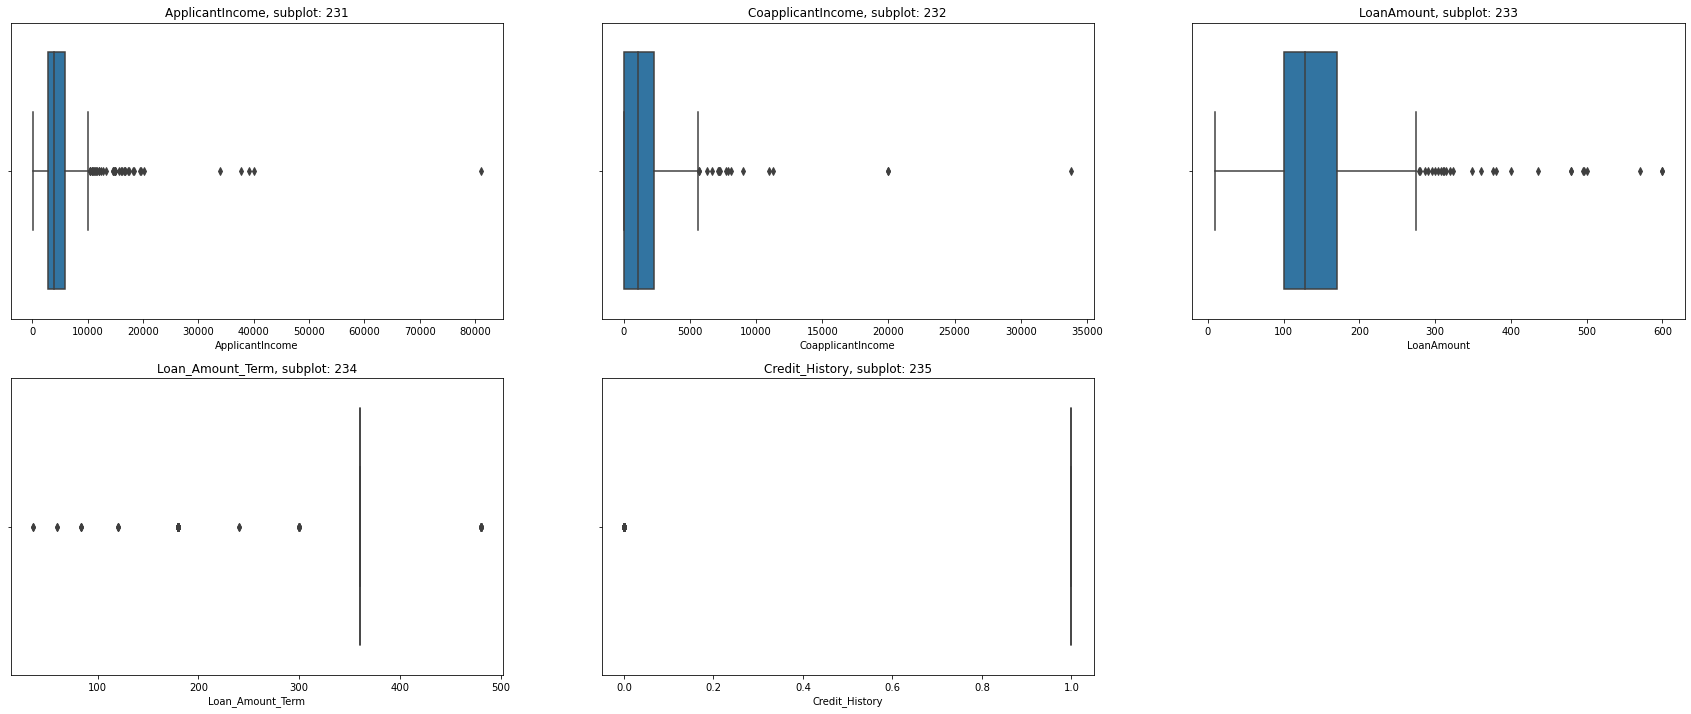

In [23]:
show_boxplots(data)

### Discretize 

In [24]:
def discretize(data):
    for column in data.columns:
        if(data[column].dtype=='float64' or data[column].dtype=='int64'):
            #print(column , data[column].dtype)
            Q1=data[column].quantile(0.25)
            Q2=data[column].quantile(0.25)
            Q3=data[column].quantile(0.25)
            IQR=Q3-Q1
            lw=Q1-1.5*IQR
            uw=Q3+1.5*IQR
            
            data[column]  = np.where((data[column]<lw) ,'lower_outlier',
                               np.where((data[column] >=lw) & (data[column] <=Q1),'low',
                               np.where((data[column]>Q1) & (data[column] <=Q2),'low_median',
                               np.where((data[column]>Q2) & (data[column] <=Q3),'high_median',
                               np.where((data[column]>Q3) & (data[column] <=Q3+1.5*IQR),'high',
                               'upper_outlier')))))

In [25]:
discretize(data)

In [26]:
data.dtypes

Gender               object
Married              object
Dependents           object
Education            object
Self_Employed        object
ApplicantIncome      object
CoapplicantIncome    object
LoanAmount           object
Loan_Amount_Term     object
Credit_History       object
Property_Area        object
Loan_Status          object
dtype: object

In [27]:
data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,Male,Yes,1,Graduate,No,upper_outlier,upper_outlier,upper_outlier,low,low,Rural,N
2,Male,Yes,0,Graduate,Yes,upper_outlier,low,lower_outlier,low,low,Urban,Y
3,Male,Yes,0,Not Graduate,No,lower_outlier,upper_outlier,upper_outlier,low,low,Urban,Y
4,Male,No,0,Graduate,No,upper_outlier,low,upper_outlier,low,low,Urban,Y
5,Male,Yes,2,Graduate,Yes,upper_outlier,upper_outlier,upper_outlier,low,low,Urban,Y


### 8.  Perform Bivariate Analysis with Class Variable 

In [28]:
tab=pd.crosstab(data['LoanAmount'],data['Loan_Status'])

In [29]:
tab

Loan_Status,N,Y
LoanAmount,,
low,3,10
lower_outlier,35,76
upper_outlier,110,246


<AxesSubplot:xlabel='LoanAmount'>

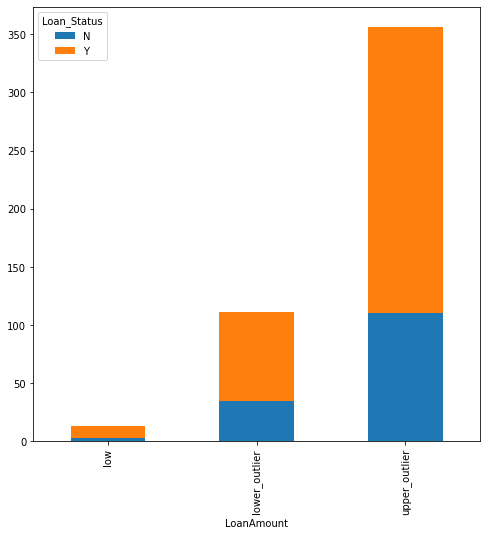

In [30]:
tab.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True)

### 9. Deal with Class Column

#### 1. Rename it as 'Y' by adding another column

In [31]:
data['y']=data['Loan_Status']

##### 2. Delete the origional column

In [32]:
del data['Loan_Status']

#### 3. Encode class as 1 and 0 values 

In [33]:
data['y'].replace(to_replace='N', value=0, inplace=True)
data['y'].replace(to_replace='Y',  value=1, inplace=True)

In [34]:
data.dtypes

Gender               object
Married              object
Dependents           object
Education            object
Self_Employed        object
ApplicantIncome      object
CoapplicantIncome    object
LoanAmount           object
Loan_Amount_Term     object
Credit_History       object
Property_Area        object
y                     int64
dtype: object

### 10. Appply One-Hot Encoding

In [35]:
df_dummies = pd.get_dummies(data)
df_dummies.head()

,y,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,...,LoanAmount_lower_outlier,LoanAmount_upper_outlier,Loan_Amount_Term_low,Loan_Amount_Term_lower_outlier,Loan_Amount_Term_upper_outlier,Credit_History_low,Credit_History_lower_outlier,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
1,0,0,1,0,1,0,1,0,0,1,...,0,1,1,0,0,1,0,1,0,0
2,1,0,1,0,1,1,0,0,0,1,...,1,0,1,0,0,1,0,0,0,1
3,1,0,1,0,1,1,0,0,0,0,...,0,1,1,0,0,1,0,0,0,1
4,1,0,1,1,0,1,0,0,0,1,...,0,1,1,0,0,1,0,0,0,1
5,1,0,1,0,1,0,0,1,0,1,...,0,1,1,0,0,1,0,0,0,1


### 11. Separate target and features 

In [36]:
# We will use the data frame where we had created dummy variables
y = df_dummies['y'].values
X = df_dummies.drop(columns = ['y'])

### 12. Tarin-Test Split

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### 13.  Fit DT to Training Data and get the prediction on test data 

In [38]:
# Import decision tree classifier here
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [39]:
# Create a decision tree classifier as clf with criterion as entropy and depth=6

clf=DecisionTreeClassifier (criterion='entropy',max_depth=6)
# fit clf on training data 
clf.fit(X_train,y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=6)

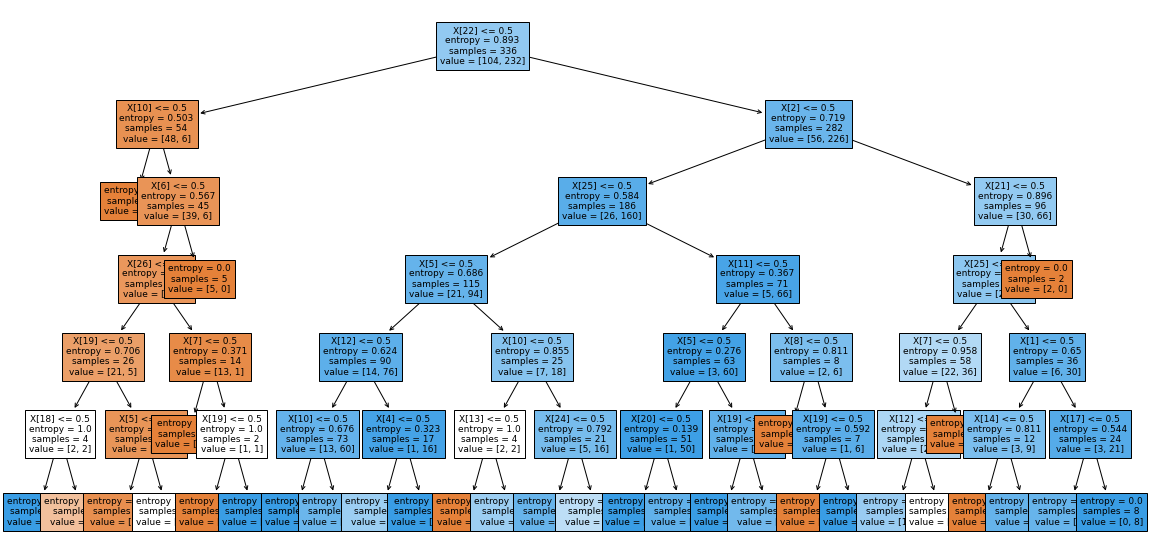

In [40]:
#plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(clf,fontsize=9,filled=True)
plt.show()

In [41]:
# Make a function to get actual column names in a list 
def ex_feature_names(data): 
    fn=[]
    for i in data.columns:
        fn.append(i)
    return fn   
    
    
    

In [42]:
# Import tree from sklearn 
from sklearn import tree

[Text(581.8088942307692, 1261.9285714285713, 'Credit_History_low <= 0.5\nentropy = 0.893\nsamples = 336\nvalue = [104, 232]\nclass = Approved'),
 Text(174.375, 1067.7857142857142, 'Self_Employed_No <= 0.5\nentropy = 0.503\nsamples = 54\nvalue = [48, 6]\nclass = Not Approved'),
 Text(147.54807692307693, 873.6428571428571, 'entropy = 0.0\nsamples = 9\nvalue = [9, 0]\nclass = Not Approved'),
 Text(201.20192307692307, 873.6428571428571, 'Dependents_2 <= 0.5\nentropy = 0.567\nsamples = 45\nvalue = [39, 6]\nclass = Not Approved'),
 Text(174.375, 679.5, 'Property_Area_Urban <= 0.5\nentropy = 0.61\nsamples = 40\nvalue = [34, 6]\nclass = Not Approved'),
 Text(107.3076923076923, 485.3571428571429, 'Loan_Amount_Term_low <= 0.5\nentropy = 0.706\nsamples = 26\nvalue = [21, 5]\nclass = Not Approved'),
 Text(53.65384615384615, 291.2142857142858, 'LoanAmount_upper_outlier <= 0.5\nentropy = 1.0\nsamples = 4\nvalue = [2, 2]\nclass = Not Approved'),
 Text(26.826923076923077, 97.07142857142867, 'entropy =

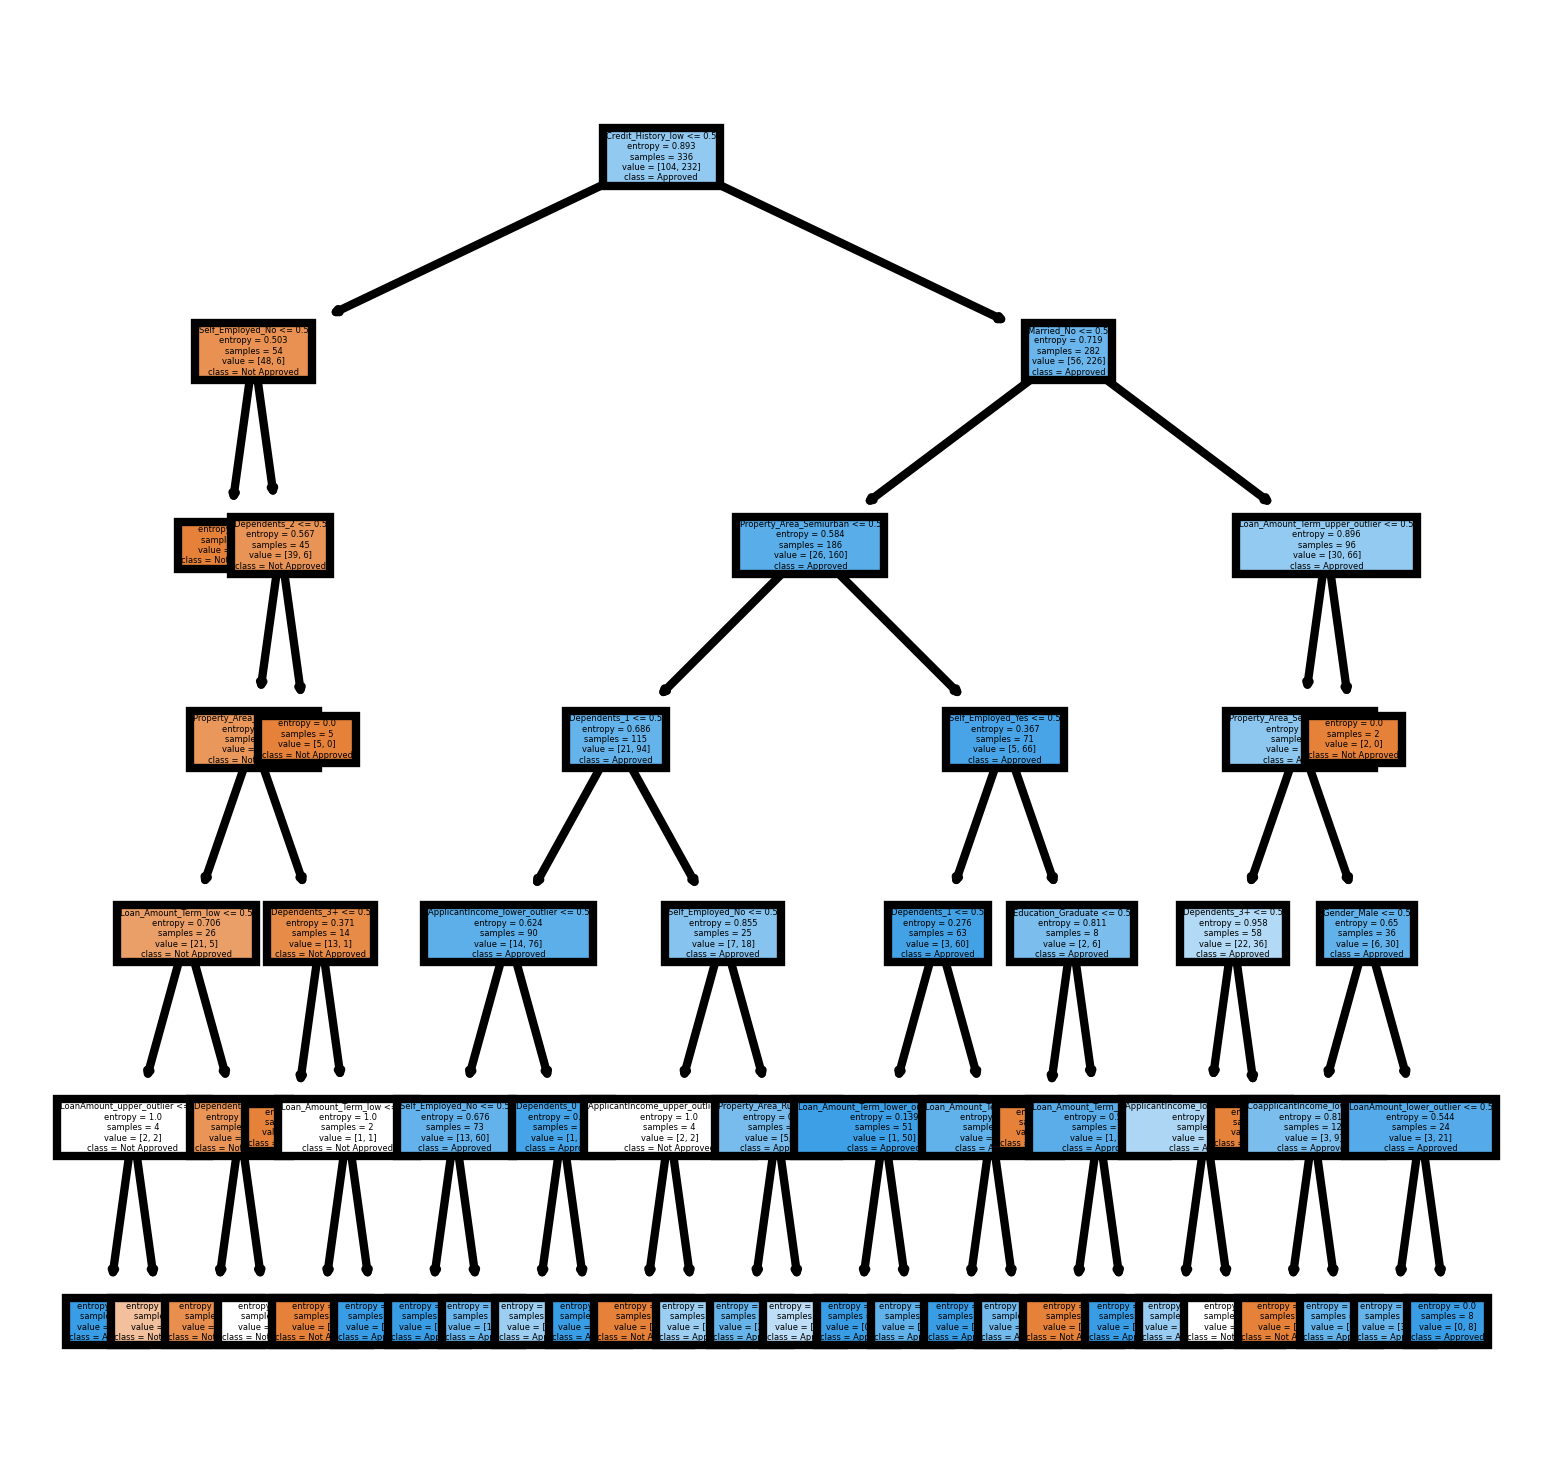

In [43]:
# Plot a decision tree using tree.plot_tree with actual feature names
fn=ex_feature_names(X)
cn=['Not Approved','Approved']
fig, axes=plt.subplots(nrows=1, ncols=1,figsize=(3,3),dpi=600)
tree.plot_tree(clf, feature_names=fn, class_names=cn, filled=True)


In [44]:
# Get the prediction on test set
clf.score(X_test,y_test)

0.7291666666666666

In [129]:
# print the feature importances 
features=clf.feature_importances_
print(features)


[0.         0.00458878 0.06068221 0.         0.02022263 0.03786204
 0.00813734 0.03417285 0.01738415 0.         0.03832641 0.01629855
 0.0168045  0.00921655 0.0163656  0.         0.         0.01410968
 0.00921655 0.06503025 0.02369253 0.02534706 0.51788807 0.
 0.00469947 0.05378703 0.00616775]


In [134]:
# Print the feature imporatnces with features names in ascending order
F1=pd.DataFrame(features,fn)
F1


,0
Gender_Female,0.000000
Gender_Male,0.004589
Married_No,0.060682
Married_Yes,0.000000
Dependents_0,0.020223
Dependents_1,0.037862
Dependents_2,0.008137
Dependents_3+,0.034173
Education_Graduate,0.017384
Education_Not Graduate,0.000000


In [138]:
F2=F1.sort_values(0)
F2

,0
Gender_Female,0.000000
Married_Yes,0.000000
Credit_History_lower_outlier,0.000000
LoanAmount_low,0.000000
CoapplicantIncome_upper_outlier,0.000000
Education_Not Graduate,0.000000
Gender_Male,0.004589
Property_Area_Rural,0.004699
Property_Area_Urban,0.006168
Dependents_2,0.008137


In [66]:
# Make a series of feature imporatnces with column names as index and importances as values


<AxesSubplot:>

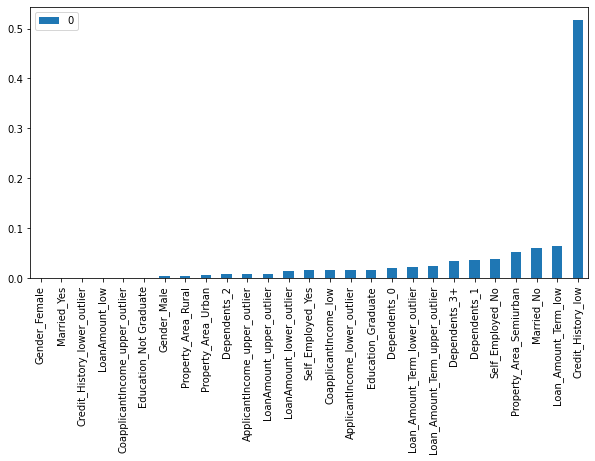

In [141]:
# Create a bar plot of features imporatances . Compare it with decision tree

F2.plot.bar(y=0,figsize=(10,5))


####  Classification Report 

In [100]:

prediction_test1 = clf.predict(X_test)
    # Print the prediction accuracy
accuracy = metrics.accuracy_score(y_test, prediction_test1)

print('============================== Model Evaluation ==============================')
print("\n Model Accuracy:" "\n", accuracy) 

============================== Model Evaluation ==============================

 Model Accuracy:
 0.7291666666666666


In [96]:
classification_report(clf)

============================== Model Evaluation ==============================
Classifier : DecisionTreeClassifier(criterion='entropy', max_depth=6)

 Model Accuracy:
 0.7291666666666666

Confusion matrix:
 [[17 27]
 [12 88]]

Classification report:
               precision    recall  f1-score   support

           0       0.59      0.39      0.47        44
           1       0.77      0.88      0.82       100

    accuracy                           0.73       144
   macro avg       0.68      0.63      0.64       144
weighted avg       0.71      0.73      0.71       144



In [83]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3) 
knn.fit(X_train,y_train)


KNeighborsClassifier(n_neighbors=3)

In [101]:

    prediction_test2 = knn.predict(X_test)
    # Print the prediction accuracy
    accuracyknn = metrics.accuracy_score(y_test, prediction_test2)

    print('============================== Model Evaluation knn ==============================')
    print('Classifier :',model)
    print("\n Model Accuracy:" "\n", accuracyknn)

============================== Model Evaluation knn ==============================
Classifier : LogisticRegression()

 Model Accuracy:
 0.6944444444444444


In [86]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,y_train)


LogisticRegression()

In [102]:

    prediction_test3 = model.predict(X_test)
    # Print the prediction accuracy
    accuracylog = metrics.accuracy_score(y_test, prediction_test3)

    print('============================== Model Evaluation knn ==============================')
    print('Classifier :',model)
    print("\n Model Accuracy:" "\n", accuracylog)

============================== Model Evaluation knn ==============================
Classifier : LogisticRegression()

 Model Accuracy:
 0.8055555555555556


In [90]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB


In [91]:
clf1 = GaussianNB()
clf1.fit(X_train, y_train)


GaussianNB()

In [103]:

    prediction_test4= clf1.predict(X_test)
    # Print the prediction accuracy
    accuracyna = metrics.accuracy_score(y_test, prediction_test4)

    print('============================== Model Evaluation knn ==============================')
    print('Classifier :',model)
    print("\n Model Accuracy:" "\n", accuracyna)

============================== Model Evaluation knn ==============================
Classifier : LogisticRegression()

 Model Accuracy:
 0.8055555555555556


In [104]:
Models= ['Decission Tree','Logistic Regression','Knn', 'Naive baye']
Accuracies = [accuracy,accuracylog,accuracyknn,accuracyna]

In [105]:
table=list(zip(Models,Accuracies))

In [106]:
table

[('Decission Tree', 0.7291666666666666),
 ('Logistic Regression', 0.8055555555555556),
 ('Knn', 0.6944444444444444),
 ('Naive baye', 0.8055555555555556)]

In [109]:
Table=pd.DataFrame(table)

In [111]:
Table.columns=['Model','Accuracy']

In [112]:
Table

,Model,Accuracy
0,Decission Tree,0.729167
1,Logistic Regression,0.805556
2,Knn,0.694444
3,Naive baye,0.805556
